# Mood-RL Behavioral Analysis

**Note:** The figures below were generated from only a subset of the original data presented in the manuscript. The findings below should not be extrapolated to those presented in [Eldar & Niv (2015)](https://www.nature.com/articles/ncomms7149).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pandas import DataFrame, concat, read_csv
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
data = read_csv('data/moodRL_data.csv')
metadata = read_csv('data/moodRL_metadata.csv')
ratings = read_csv('data/moodRL_ratings.csv')

## Section 1: Task Performance
In this first section, we quantify the participants' performance on the slot machines task. Performance is quantified by the fraction of optimal decisions made, where optimality is defined by choosing the slot machine with objectively higher reward probability.

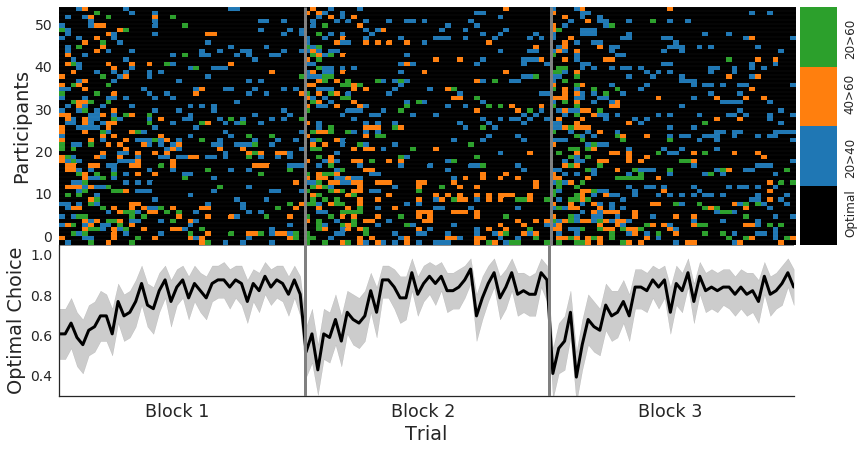

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Subset data to learning blocks.
optimal_choice = data[data.Block<4].copy()

## Re-code machines to range [1-3].
optimal_choice[['M1','M2','Choice']] = np.where(optimal_choice[['M1','M2','Choice']] % 3, 
                                                optimal_choice[['M1','M2','Choice']] % 3, 3)

## Re-code trials.
optimal_choice['Trial'] += (optimal_choice['Block'] - 1) * optimal_choice['Trial'].max()

## Find trials where optimal choice is made. 
optimal_choice['Optimal'] = np.equal(optimal_choice['Choice'], 
                                     optimal_choice[['M1','M2']].max(axis=1))

## Classify errors.
optimal_choice['Error'] = np.where(optimal_choice['Optimal'],
                                   optimal_choice['Optimal'],
                                   optimal_choice[['M1','M2']].sum(axis=1)-1)

## Reverse code errors 3 (M1 > M3) and 4 (M2 > M3).
optimal_choice['Error'] = np.where(optimal_choice.Error==3, 4, 
                                   np.where(optimal_choice.Error==4, 3, 
                                            optimal_choice.Error))

## Organize error data.
n_subjects = optimal_choice.Datetime.unique().size
n_trials = optimal_choice.Trial.max()
errors = optimal_choice.Error.values.reshape(n_subjects, n_trials).astype(int)

## Sort by weighted sum of errors.
sort_ix = np.argsort(errors.sum(axis=-1))
errors = errors[sort_ix]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize figure.
fig = plt.figure(figsize=(12,6))

## Initialize canvas and divider.
gs = gridspec.GridSpec(1,1)
gs.update(left=0.05, right=0.95, bottom=0.4, top=0.95, hspace=0, wspace=0)
ax = plt.subplot(gs[0, 0])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

## Plot.
cmap = ListedColormap(np.insert( sns.color_palette(n_colors=3).as_hex(), 0, 'k' ) )
sns.heatmap(errors, cmap=cmap, cbar=True, ax=ax, cbar_ax=cax)

## Add info.
ax.vlines([42,84], 0, n_subjects, lw=3, color='grey')
ax.hlines(np.arange(n_subjects), 0, n_trials, lw=0.05, color='w')
ax.set(xticks=[], yticks=np.arange(0,n_subjects,10)+4, ylabel='Participants')
ax.set_yticklabels(np.arange(0,n_subjects,10)[::-1], fontsize=14)

## Update colorbar.
cbar = ax.collections[0].colorbar
cbar.set_ticks([1.4, 2.1, 2.9, 3.6])
cbar.ax.set_yticklabels(['Optimal', '20>40', '40>60', '20>60'], fontsize=12,
                        rotation=90, va='center')

## Initialize canvas.
gs = gridspec.GridSpec(1,1)
gs.update(left=0.05, right=0.9, bottom=0.05, top=0.4, hspace=0, wspace=0)
ax = plt.subplot(gs[0, 0])

## Plot mean accuracy.
sns.lineplot('Trial','Optimal',data=optimal_choice, lw=3, color='k', ax=ax)
ax.vlines([42.8, 84.4], 0.3, 1.05, lw=3, color='grey', zorder=10)
ax.hlines(1.05, 1, n_trials, color='grey')
ax.set(xlim=(1, n_trials), xticks=[21,63,105], xticklabels=['Block 1', 'Block 2', 'Block 3'],
       ylim=(0.3, 1.05), yticks=[0.4,0.6,0.8,1.0], ylabel='Optimal Choice')
ax.set_yticklabels([0.4,0.6,0.8,1.0], fontsize=14)
sns.despine(ax=ax)

**Figure 1:** Participant performance on the slot machines task. Participants decisions were first categorized into optimal and non-optimal decisions; non-optimal decisions were then categorized by trial type (e.g. 20% vs. 40%, 40% vs. 60%, 20% vs. 60%). As can be observed, participants were successful in learning the reward maximizing machines, with optimal choice rates reaching over 80% on average by the final trial. As learning progressed, non-optimal choices in the 40/60 and 20/60 trials diminished, though errors in the 20/40 trials were still frequent. 

### Subjective estimates of reward likelihoods
The results above demonstrate that participants were able to learn the objective reward likelihoods, at least implicitly. Next we asses whether their subjective self-report estimates of reward likelihoods were close to the objective likelihoods.

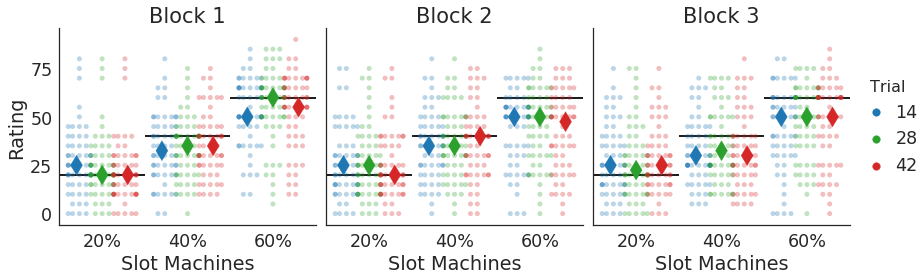

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

estimates = ratings[ratings.Variable != 'Mood'].copy()

estimates['Variable'] = np.where(estimates['Variable'].astype(int) % 3, 
                                 estimates['Variable'].astype(int) % 3, 3)

gb = estimates.groupby(['Block','Variable','Trial']).Rating.median()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)
palette = ['#1f77b4', '#2ca02c', '#d62728']

for ax, block in zip(axes, estimates.Block.unique()):
    
    ## Plot all points.
    sns.swarmplot('Variable', 'Rating', 'Trial', estimates[estimates.Block==block], 
                  dodge=True, palette=palette, alpha=0.3, ax=ax)
    
    ## Plot median point (weird seaborn error forcing ugly code. sorry.)
    x = np.array([np.arange(-0.3,0.4,0.3) + i for i in np.arange(3)])
    ax.scatter(x, gb[block].values, s=200, marker='d', color=palette, zorder=2)
        
    ## Add info.
    ax.hlines(20, -0.5, 0.5, zorder=1)
    ax.hlines(40,  0.5, 1.5, zorder=1)
    ax.hlines(60,  1.5, 2.5, zorder=1)
    ax.set(xlabel='Slot Machines', xticklabels=['20%','40%','60%'], ylabel='', title='Block %s' %block)
    if block == 1: ax.set_ylabel('Rating')
    
    if not block == 3: ax.legend_.set_visible(False)
    else: 
        ax.legend(loc=7, bbox_to_anchor=(1.3,0.5), borderpad=0, handletextpad=0.1)
        ax.legend_.set_title('Trial', prop=dict(size=16))
    
sns.despine()
plt.tight_layout()

**Figure 2:** Subject estimates of reward likelihood. As might be expected based on task performance, participants on average correctly estimated the order of machine reward likelihoods: 20% > 40% > 60%. Consistent with the observation above that 20/40 errors persisted even in late learning, the average subjective estimates of the 40% probability machine were systematically less than truth. 

## Section 2: Mood Ratings
In this first section, we describe the temporal profiles of participants' self-reported mood ratings. We count the number of participants exhibiting  low variance and/or always positive/negative mood profiles (see *Demos* notebook for details).

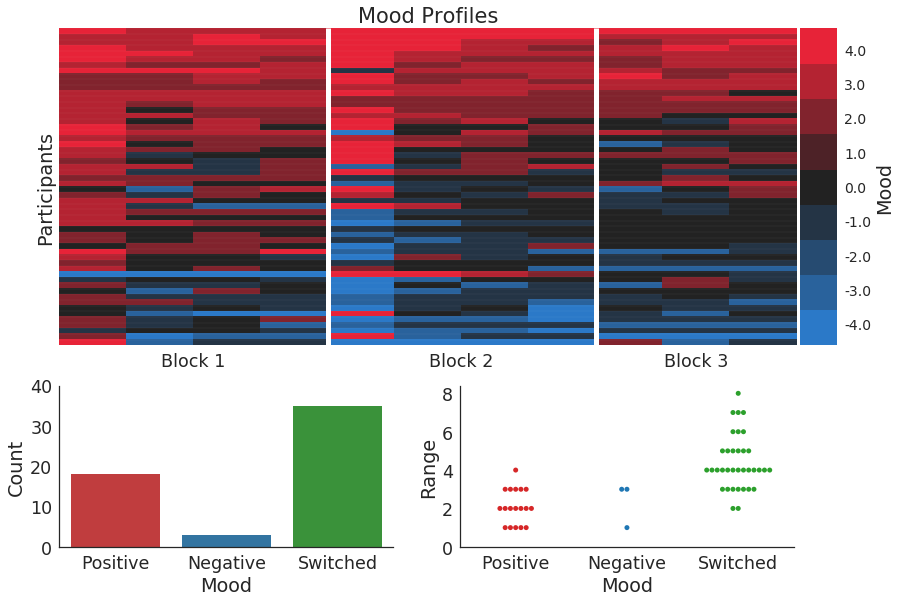

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Subset data.
mood = ratings[ratings.Variable=='Mood'].copy()

## Define metadata.
n_subjects = mood.Datetime.unique().size
trials = np.unique( (mood.Block-1) * 42 + mood.Trial)
n_trials = trials.size

## Extract and reshape mood data.
mood = mood.Rating.values.reshape(n_subjects, n_trials)

## Sort.
sort_ix = np.argsort(mood.mean(axis=-1))
mood = mood[sort_ix[::-1]]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Count.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Bin participants.
positive_only = np.all(mood >= 0, axis=-1)
negative_only = np.all(mood <= 0, axis=-1)
switched_sign = np.any(mood > 0, axis=-1) * np.any(mood < 0, axis=-1)

## Compute range.
mood_range = np.ptp(mood, axis=-1)

## Convert to DataFrame.
clusters = DataFrame(dict(Positive = positive_only, 
                          Negative = negative_only,
                          Switched = switched_sign,
                          Range = mood_range))

clusters = clusters.melt(id_vars='Range', var_name='Mood')
clusters = clusters[clusters.value]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,8))

## Initialize canvas and divider.
gs = gridspec.GridSpec(1,1)
gs.update(left=0.05, right=0.95, bottom=0.4, top=0.95, hspace=0, wspace=0)
ax = plt.subplot(gs[0, 0])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

## Plot.
cmap = sns.diverging_palette(250, 10, s=90, l=50, n=9, center="dark")
sns.heatmap(mood, vmin=-3, vmax=3, cmap=cmap, cbar_kws=dict(label='Mood'), ax=ax, cbar_ax=cax)

## Add info.
ax.vlines([4,8], 0, n_subjects, lw=5, color='w')
ax.hlines(np.arange(n_subjects), 0, n_trials, lw=0.05, color='w')
ax.set(xticks=[2,6,9.5], yticks=[], ylabel='Participants', title='Mood Profiles')
ax.set_xticklabels(['Block 1', 'Block 2', 'Block 3'], rotation=0)

## Update colorbar.
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.linspace(-4,4,9)*0.65)
cbar.ax.set_yticklabels(np.linspace(-4,4,9), fontsize=14)

## Initialize canvas.
gs = gridspec.GridSpec(1,2)
gs.update(left=0.05, right=0.9, bottom=0.05, top=0.33, hspace=0, wspace=0.2)

## Plot countplot.
ax = plt.subplot(gs[0, 0])
palette = ['#d62728', '#1f77b4', '#2ca02c']
sns.countplot('Mood', data=clusters, order=['Positive','Negative','Switched'],
              palette=palette, ax=ax)
ax.set(yticks=np.linspace(0,40,5), ylabel='Count')
sns.despine(ax=ax)

## Plot stripplot.
ax = plt.subplot(gs[0, 1])
sns.swarmplot('Mood', 'Range', data=clusters, order=['Positive','Negative','Switched'],
              palette=palette, ax=ax)
ax.set(yticks=np.arange(0,clusters.Range.max()+1,2), ylabel='Range')
sns.despine(ax=ax)

**Figure 3:** Mood profiles of participants. (Top) The temporal evolution of all participants' mood ratings (sorted by average mood). As can be observed, some participants remain all positive (red) or negative (blue). (Bottom left) Counts of the number of participants who remained positive ($m \geq 0$), negative ($m \leq 0$), or switched signs across all nine self-report ratings. (Bottom right) The range of participants' mood profiles. 

### Mood and questionnaires

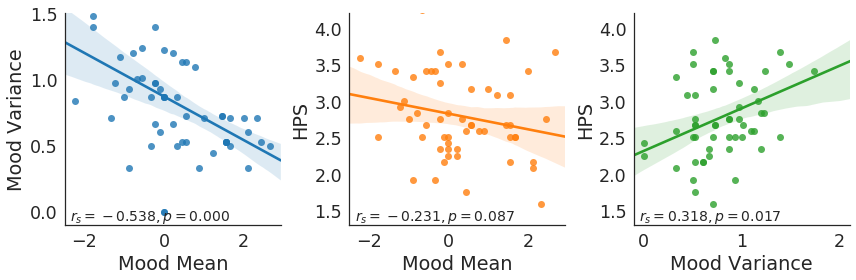

In [5]:
from scipy.stats import spearmanr

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Limit mood data to trials during task.
mood = ratings[np.logical_and(ratings.Trial > 0, ratings.Variable=='Mood')].copy()

## Collapse across trials.
mood = mood.groupby('Datetime').Rating
mood = DataFrame([mood.mean(), mood.std()]).T.reset_index()

## Append HPS scale metadata.
mood = mood.merge(metadata[['Datetime','IPIP_hps']], on='Datetime')

## Update columns.
mood.columns = ['Datetime', 'Mood Mean', 'Mood Variance', 'HPS']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot correlations.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))

## Plot mean/variance.
sns.regplot('Mood Mean', 'Mood Variance', data=mood, ax=axes[0])
axes[0].set(ylim=(-0.1,1.5))
axes[0].annotate(r'$r_s = %0.3f, p = %0.3f$' %spearmanr(mood['Mood Mean'], mood['Mood Variance']),
            xy=(0,0), xytext=(0.025,0.02), xycoords='axes fraction', fontsize=14)

## Plot mean/HPS.
sns.regplot('Mood Mean', 'HPS', data=mood, ax=axes[1])
axes[1].set(ylim=(1.3,4.2))
axes[1].annotate(r'$r_s = %0.3f, p = %0.3f$' %spearmanr(mood['Mood Mean'], mood['HPS']),
            xy=(0,0), xytext=(0.025,0.02), xycoords='axes fraction', fontsize=14)

## Plot variance/HPS.
sns.regplot('Mood Variance', 'HPS', data=mood, ax=axes[2])
axes[2].set(xlim=(-0.1,2.1), ylim=(1.3,4.2))
axes[2].annotate(r'$r_s = %0.3f, p = %0.3f$' %spearmanr(mood['Mood Variance'], mood['HPS']),
            xy=(0,0), xytext=(0.025,0.02), xycoords='axes fraction', fontsize=14)

# ax.set_xlim(1.3, 4)
sns.despine()
plt.tight_layout()

### Wheel of fortune mood manipulation
We turn to the effects of the wheel of fortune (WoF) manipulation on mood.

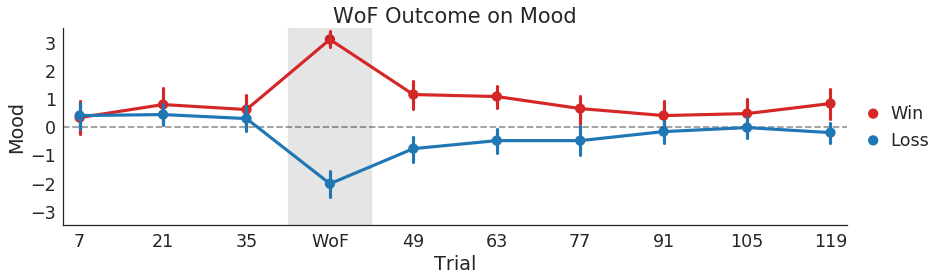

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Subset data.
mood = ratings[ratings.Variable=='Mood'].copy()

## Update trials.
mood['Trial'] += (mood.Block-1) * 42

## Exclude pre-block 1.
mood = mood[mood.Trial > 0]

## Merge WoF info.
mood = mood.merge(metadata[['Datetime','WoF']], on='Datetime')
mood['Outcome'] = np.where(mood.WoF > 0, 'Win', 'Loss')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
palette = ['#d62728','#1f77b4']

## Plot.
sns.pointplot('Trial', 'Rating', 'Outcome', data=mood, 
              palette=palette, ax=ax)

## Add info.
ax.hlines(0, -0.2, 10.2, linestyle='--', alpha=0.4)
ax.fill_between([2.5,3.5],-3.5,3.5,color='k',alpha=0.1)
ax.set(xlim=(-0.2,9.2), ylim=(-3.5,3.5), yticks=np.arange(-3,4), ylabel='Mood', title='WoF Outcome on Mood')
ax.set_xticklabels([7, 21, 35, 'WoF', 49, 63, 77, 91, 105, 119])
ax.legend(loc=7, bbox_to_anchor=(1.125,0.5), handletextpad=0)

sns.despine()
plt.tight_layout()

**Figure 4:** Wheel of Fortune (WoF) outcome affects mood. Participants who lost the WoF exhibited decreased mood afterwards.  

### Wheel of Fortune and machine preference
We reproduce the findings of the original manuscript, namely that participants who lost the Wheel of Fortune prefer slot machines with equal reward likelihood from the block prior to loss.

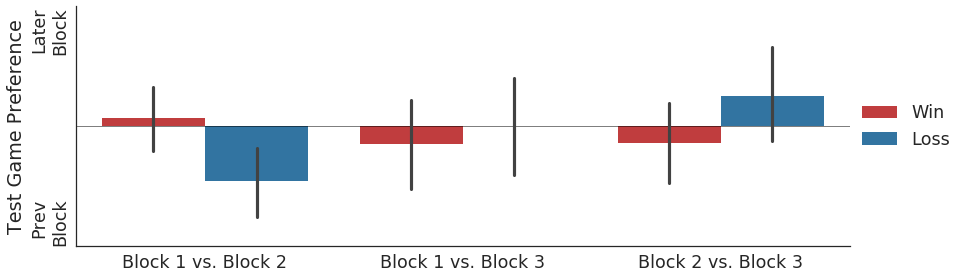

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Discrimination check.
ix = np.logical_and(data.Block==4, data.Choice.notnull())
discrimination = data[ix].copy()
discrimination = discrimination[np.equal(discrimination.M1 % 3, discrimination.M2 % 3)]
discrimination[['Choice','M1','M2']] = discrimination[['Choice','M1','M2']].apply(lambda col: np.ceil(col / 3))
discrimination['Discrimination'] = discrimination[['M1','M2']].sum(axis=1)
discrimination['Choice'] = np.equal(discrimination['Choice'], discrimination[['M1','M2']].max(axis=1))

gb = discrimination.groupby(['Datetime','Discrimination']).Choice.mean().reset_index()
gb = gb.merge(metadata[['Datetime','WoF']], on='Datetime')
gb['Outcome'] = np.where(gb.WoF > 0, 'Win', 'Loss')
gb['Choice'] -= 0.5

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
palette = ['#d62728','#1f77b4']

## Plot.
sns.barplot('Discrimination', 'Choice', 'Outcome', data=gb, palette=palette, ax=ax)

## Add info.
ax.hlines(0, -0.5, 2.5, lw=0.5)
ax.set(xticklabels=['Block 1 vs. Block 2', 'Block 1 vs. Block 3', 'Block 2 vs. Block 3'],  
       xlabel='', ylim=(-0.25,0.25), yticks=[-0.2,0.2], ylabel='Test Game Preference')
ax.set_yticklabels(['Prev\nBlock','Later\nBlock'], rotation=90, va='center')
ax.legend(loc=7, bbox_to_anchor=(1.15,0.5))

sns.despine()
plt.tight_layout()

**Figure 5:** Wheel of Fortune outcome affects machine preference. In comparing machines with equal reward likelihoods, participants who lost the WoF preferred those machines from the block prior to loss.

## Section 3: Reaction Times
We next search for trends in the reaction times during learning. 

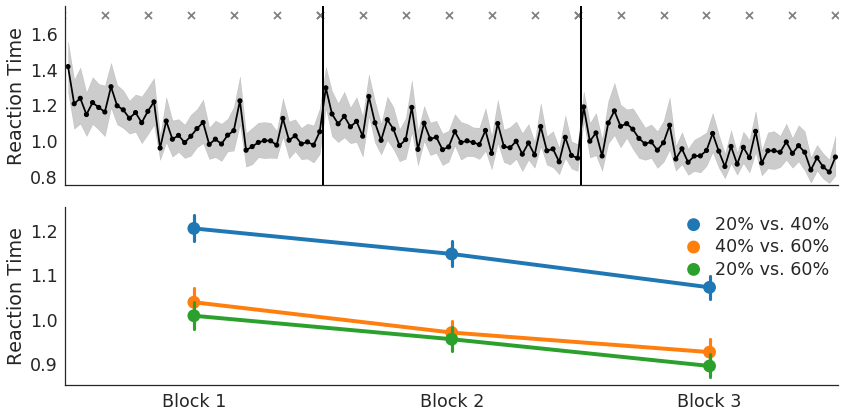

In [8]:
from pandas import Categorical

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Subset data.
rt = data[np.logical_and(data.Block < 4, data.RT.notnull())].copy()

## Define optimal trials.
rt['Optimal'] = np.equal(rt[['M1','M2']].max(axis=1), rt['Choice'])

## Span trials between 1 and 126.
rt.Trial += (rt.Block - 1) * rt.Trial.max()
rt.Trial -= 1

## Classify types of trials.
hue = np.where(rt[['M1','M2']] % 3, rt[['M1','M2']] % 3, 3).sum(axis=1)
hue = Categorical(hue, categories=[3,5,4], ordered=True).rename_categories(['20% vs. 40%', 
                                                                            '40% vs. 60%', 
                                                                            '20% vs. 60%'])
rt['TrialType'] = hue

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2,1,figsize=(12,6))

## Plot RTs.
sns.lineplot('Trial', 'RT', data=rt, color='k', zorder=0, ax=axes[0])
sns.pointplot('Trial', 'RT', data=rt, color='k', scale=0.5, join=False, ci=None, zorder=10, ax=axes[0])

## Add info.
queries = np.concatenate([ratings.Trial.unique() + b * 42 for b in np.arange(3)])
axes[0].scatter(queries-1, np.ones_like(queries) * 1.7, marker='x', color='grey')
axes[0].vlines([41.5,83.5], 0.75, 1.75, linewidth=2)
axes[0].set(xlim=(rt.Trial.min()-0.5, rt.Trial.max()+0.5), xlabel='', xticks=[], 
            ylim=(0.75, 1.75), ylabel='Reaction Time')

## Pointplot.
sns.pointplot('Block', 'RT', 'TrialType', rt, scale=1.25, ax=axes[1])
axes[1].set(xticklabels=['Block 1', 'Block 2', 'Block 3'], xlabel='', ylabel='Reaction Time')
axes[1].legend(loc=1, borderpad=0, labelspacing=0.25, handletextpad=0.25, title='')

sns.despine()
plt.tight_layout()

**Figure 6:** Reaction times reflect learning. Several important trends can be observed in the reaction times. First, reaction times decrease with learning. Second, reaction times decrease by block (perhaps reflecting increased decision confidence). Third, reaction times increased following mood/subject estimate querying (top row, gray Xs). Fourth, reaction times reflect the differences in expected value of machines: reaction times were least in the 20/60 and 40/60 conditions but higher in the 20/40 condition (perhaps reflecting the increase in subjective similarity between those two machines).

## Section 4: Modeling

### Subjective estimates

In [9]:
from statsmodels.api import OLS

## Compute reward rate within subjects by block / choice.
gb = data[data.Block<4].copy()
gb['Outcome'] *= 4
gb['Choice'] = np.where(gb.Choice % 3, gb.Choice % 3, 3)
gb = gb.groupby(['Block','Choice','Subject',]).Outcome.mean()

# ## Compute difference in reward rate between pre-/post-WoF blocks. Merge.
df = (gb[2] - gb[1]).reset_index().merge((gb[3] - gb[1]).reset_index(), on=['Subject','Choice'])
df.columns = ['Machine','Subject','b12','b13']
df = df.melt(id_vars=['Subject','Machine'], var_name='Block', value_name='RR')

## Compute subjective estimates within subjects by block / choice.
gb = ratings[ratings.Trial==42].copy()
gb['Variable'] = np.where(gb.Variable.astype(float) % 3, gb.Variable.astype(float) % 3, 3)
gb = gb.groupby(['Block','Variable','Subject']).Rating.mean()

## Compute difference in subject estimates between pre-/post-WoF blocks. Merge.
gb = (gb[2] - gb[1]).reset_index().merge((gb[3] - gb[1]).reset_index(), on=['Variable','Subject'])
gb.columns = ['Machine', 'Subject', 'b12', 'b13']
gb = gb.melt(id_vars=['Subject','Machine'], var_name='Block', value_name='SR')

## Merge.
df = df.merge(gb, on=['Subject','Machine','Block'])
df.SR /= 100

## Merge metadata.
df = df.merge(metadata[['Subject','WoF','IPIP_hps']], on='Subject')
df['WoF'] = np.where(df['WoF'] > 0, 1, 0)

## Fit regression model.
OLS.from_formula('SR ~ RR + Block * WoF * IPIP_hps ', data=df).fit().summary2()

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
========================================================================
Model:                 OLS                Adj. R-squared:       0.033   
Dependent Variable:    SR                 AIC:                  37.0602 
Date:                  2018-02-07 00:34   BIC:                  71.4142 
No. Observations:      336                Log-Likelihood:       -9.5301 
Df Model:              8                  F-statistic:          2.443   
Df Residuals:          327                Prob (F-statistic):   0.0140  
R-squared:             0.056              Scale:                0.063673
------------------------------------------------------------------------
                           Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
------------------------------------------------------------------------
Intercept                  0.0029   0.1497  0.0195 0.9844 -0.2916 0.2974
Block[T.b13]               0.0116   0.2114  0.0548 0.9563 -0.4043 0.4275
RR                         0.6075   0.1437  4.2289 0.0000  0.3249 0.8901
WoF                        0.0096   0.1992  0.0484 0.9614 -0.3822 0.4015
Block[T.b13]:WoF          -0.0311   0.2817 -0.1105 0.9121 -0.5853 0.5231
IPIP_hps                  -0.0175   0.0531 -0.3294 0.7421 -0.1220 0.0870
Block[T.b13]:IPIP_hps      0.0086   0.0751  0.1145 0.9089 -0.1391 0.1563
WoF:IPIP_hps               0.0092   0.0700  0.1317 0.8953 -0.1285 0.1469
Block[T.b13]:WoF:IPIP_hps -0.0006   0.0990 -0.0056 0.9955 -0.1953 0.1942
------------------------------------------------------------------------
Omnibus:                2.288           Durbin-Watson:             2.491
Prob(Omnibus):          0.319           Jarque-Bera (JB):          2.242
Skew:                   -0.059          Prob(JB):                  0.326
Kurtosis:               3.382           Condition No.:             116  
========================================================================

"""

### Preferences: Block 1 vs Block 2

In [10]:
import pystan
from scripts.diagnostics import *
from scripts.utilities import zscore

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Discrimination check.
ix = np.logical_and(data.Block==4, data.Choice.notnull())
df = data[ix].copy()

## Limit to trials comparing equal probability machines.
df = df[np.where(np.abs( np.diff(df[['M1','M2']], axis=1)).squeeze() % 3, False, True)]

## Remove trials comparing blocks 2 and 3.
df = df[np.ceil(df[['M1','M2']] / 3).sum(axis=1) < 5]
df.Block = np.ceil(df[['M1','M2']].max(axis=1) / 3).astype(int)

## Recode trials as choosing Block 1 (0) or not (1).
df['Choice'] = (df.Choice > 3).astype(int)

## Tally preference for post-WoF machines. 
gb = df.groupby(['Subject','Block']).Choice
df = gb.sum().reset_index().merge(gb.count().reset_index(), on=['Subject','Block'])
df.columns = ['Subject','Block','postWoF','Total']

## Compute difference in outcomes.
outcomes = data[data.Block < 4].groupby(['Block','Subject']).Outcome.sum() * 4
outcomes = (outcomes[2] - outcomes[1]).reset_index().merge((outcomes[3] - outcomes[1]).reset_index(), on='Subject')
outcomes.columns = ['Subject', 2, 3]
outcomes = outcomes.melt(id_vars='Subject', var_name='Block', value_name='Reward')
df = df.merge(outcomes, on=['Subject','Block'])

## Compute difference in average subjective estimates.
estimates = ratings[np.logical_and(ratings.Block<4, ratings.Trial==42)].groupby(['Block','Subject']).Rating.mean()
estimates = (estimates[2] - estimates[1]).reset_index().merge((estimates[3] - estimates[1]).reset_index(), on='Subject')
estimates.columns = ['Subject', 2, 3]
estimates = estimates.melt(id_vars='Subject', var_name='Block', value_name='Likelihood')
df = df.merge(estimates, on=['Subject','Block'])
df.Block += -2

## Append metadata.
df = df.merge(metadata[['Subject','WoF','IPIP_hps']], on='Subject')
df['WoF'] = (df['WoF'] > 0).astype(int)

## Z-score continuous values.
df['Reward'] = zscore(df['Reward'])
df['Likelihood'] = zscore(df['Likelihood'])
df['IPIP_hps'] = zscore(df['IPIP_hps'])

## Assemble design matrix for regression.
X = np.vstack([
    
        ## Main effects.
        np.ones(df.shape[0]),
        df.Reward.values,
        df.Likelihood.values,
        df.Block.values,
        df.WoF.values,
        df.IPIP_hps.values,
    
        ## 2-way interactions.
        df[['IPIP_hps','WoF']].prod(axis=1).values,

    ]).T.astype(float)

## Assemble data dictionary.
dd = dict(N = X.shape[0], M = X.shape[1], Y = df.postWoF.values, T = df.Total.values, X = X)

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model with Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Fit model.
file = 'stan_models/moodRL_block_preference.stan'
fit = pystan.stan(file=file, data=dd, iter=5500, warmup=5000, thin=1, chains=4, 
                  n_jobs=4, seed=47404)
check_div(fit); check_treedepth(fit); check_energy(fit); check_n_eff(fit), check_rhat(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_76df3cab63f53fb4a77879bb02ce8251 NOW.
/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


0.0 of 2000 iterations ended with a divergence (0.0%)
0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior
n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters


(None, None)

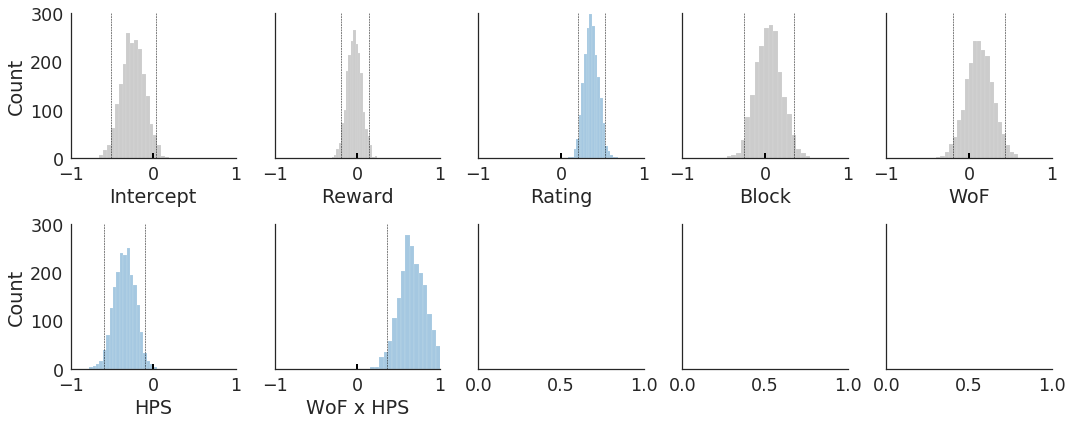

In [12]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract parameters.
extract = fit.extract()
beta = extract['beta']

summary = fit.summary()
summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

## Initialize canvas.
fig, axes = plt.subplots(2, 5, figsize=(15,6), sharey=True)

## Plot.
labels = ['Intercept', 'Reward', 'Rating', 'Block', 'WoF', 'HPS', 
          'WoF x HPS', '3-way']

for i, arr, label in zip(range(10), beta.T, labels):
    
    ## Select color.
    lb, ub = summary.loc['beta[%s]' %i, ['2.5%','97.5%']]
    if np.logical_xor(lb > 0, ub > 0): color='grey'
    else: color = '#1f77b4'
    
    ## Plot.
    sns.distplot(arr, bins=20, kde=False, color=color, hist_kws=dict(edgecolor='w'), ax=axes[i//5,i%5])
    
    ## Plot HDI.
    axes[i//5,i%5].vlines([lb,ub],0,300,lw=0.5,linestyle='--')
    axes[i//5,i%5].vlines(0,0,10,lw=2,color='k')
    axes[i//5,i%5].set(xlim=(-1,1), ylim=(0,300), xlabel=label)
    axes[0,0].set(ylabel='Count')
    axes[1,0].set(ylabel='Count')
    
sns.despine()
plt.tight_layout()

In [13]:
## Prepare data.
df['HPS'] = np.where(df['IPIP_hps'] > 0, 'High', 'Low')
df['WoF'] = np.where(df['WoF'], 'Win', 'Loss')
df['Preference'] = df.postWoF / df.Total - 0.5

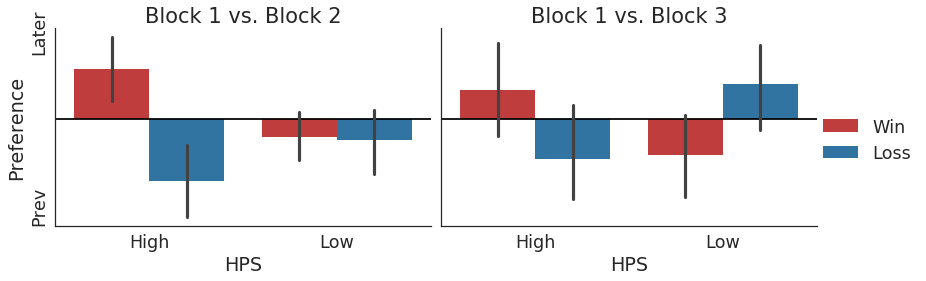

In [14]:
## Plot.
g = sns.FacetGrid(df, col='Block', size=4, aspect=1.5)
g.map(sns.barplot, 'HPS', 'Preference', 'WoF', order=['High','Low'], 
      hue_order=['Win','Loss'], palette=['#d62728','#1f77b4'])

for ax, title in zip(g.axes.squeeze(), ['Block 1 vs. Block 2', 'Block 1 vs. Block 3']): 
    ax.hlines(0,-0.5,2.5)
    ax.set_title(title)

g.axes.squeeze()[0].set_yticks([-0.25,0.25])
g.axes.squeeze()[0].set_yticklabels(['Prev', 'Later'], rotation=90, va='center')
g.add_legend()